In [ ]:
!pip install pandas
!pip install matplotlib
!pip install arango_datasets
!pip install networkx
!pip install nx-arangodb
!pip install  inspect
!pip install  scipy
!pip install langgraph
!pip install langchain_openai
!pip install langchain_community

In [118]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re , random

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

from dotenv import load_dotenv

load_dotenv() #loads .env file  to get open api key


True

In [88]:
!wget https://mitre.box.com/shared/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip 
!unzip aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip
!ls csv

--2025-03-07 16:08:50--  https://mitre.box.com/shared/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip
Resolving mitre.box.com (mitre.box.com)... 74.112.186.157
Connecting to mitre.box.com (mitre.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip [following]
--2025-03-07 16:08:50--  https://mitre.box.com/public/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip
Reusing existing connection to mitre.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mitre.app.box.com/public/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip [following]
--2025-03-07 16:08:50--  https://mitre.app.box.com/public/static/aw9po06ypfb9hrau4jamtvtz0e5ziucz.zip
Resolving mitre.app.box.com (mitre.app.box.com)... 74.112.186.157
Connecting to mitre.app.box.com (mitre.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [142]:
df1 = pd.read_csv('./csv/patients.csv')
df1['patient_name'] = df1['FIRST'] + ' ' + df1['LAST']
print(df1.shape)
df2 = pd.read_csv('./csv/conditions.csv')
print(df2.shape)
df2 = df2.merge(df1[['Id', 'patient_name']], right_on='Id', left_on="PATIENT", how='inner')
print(df2.shape)
df3 = pd.read_csv('./csv/medications.csv')
print(df3.shape)

(1163, 26)
(38094, 6)
(38094, 8)
(56430, 13)


In [143]:
df1.head(2) #patients

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,patient_name
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaN,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,...,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255,Damon455 Langosh790
1,c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8,2005-07-04,NaN,999-49-3323,S99941126,NaN,NaN,Thi53,Wunsch504,NaN,...,972 Tillman Branch Suite 48,Bellingham,Massachusetts,Norfolk County,NaN,42.035213,-71.482519,402723.4150,14064.1350,Thi53 Wunsch504


In [144]:


G = nx.Graph()
print(f"Number of nodes in the graph: {G.number_of_nodes()}")

# Create Gender and Marital Status nodes
G.add_node('male', node_type='Gender', name = 'Male')
G.add_node('female', node_type='Gender', name = 'Female')
G.add_node('married', node_type='MaritalStatus', name = 'Married')
G.add_node('single', node_type='MaritalStatus', name = 'Single')    

print(f"Number of nodes in the graph: {G.number_of_nodes()}")
# Process each patient in the dataframe
for _, row in df1.iterrows():
    # Create patient node with ID and Name
    patient_id = row['Id']
    #patient_name = f"{row['FIRST']} {row['LAST']}"
    patient_name = row['patient_name'].strip()
    G.add_node(patient_id, node_type='Patient', name=patient_name)
    
    # Add gender relationship
    if row['GENDER'] == 'M':
        G.add_edge(patient_id, 'male', relationship='HAS_GENDER')
    elif row['GENDER'] == 'F':
        G.add_edge(patient_id, 'female', relationship='HAS_GENDER')
    
    # Add marital status relationship
    if row['MARITAL'] == 'M':
        G.add_edge(patient_id, 'married', relationship='HAS_MARITAL_STATUS')
    elif row['MARITAL'] == 'S':
        G.add_edge(patient_id, 'single', relationship='HAS_MARITAL_STATUS')
    
print(f"Number of nodes in the graph: {G.number_of_nodes()}")



Number of nodes in the graph: 0
Number of nodes in the graph: 4
Number of nodes in the graph: 1167


In [145]:
df2.sample(2) #conditions

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,Id,patient_name
25865,1931-08-04,NaN,b5d02e28-4948-f7d4-d4dc-a21d692d2b07,235ca77a-8be4-9041-2380-d192685f875b,5251000175109,Received certificate of high school equivalenc...,b5d02e28-4948-f7d4-d4dc-a21d692d2b07,Kristofer887 Schmitt836
28534,2018-10-07,2018-12-02,8b75c459-60b7-ff60-9ef5-74f64131beda,84c9bba0-1dcf-5e97-74a4-7b04dbd334f5,73595000,Stress (finding),8b75c459-60b7-ff60-9ef5-74f64131beda,Marilyn850 Zieme486


In [146]:
# Process each condition in the dataframe
for _, row in df2.iterrows():
    # Create patient node with ID and Name
    encounter_id = row['ENCOUNTER']
    encounter_date = row['START']
    condition_id = row['CODE']
    condition_name = row['DESCRIPTION']
    patient_id = row['PATIENT']
    patent_name = row['patient_name'].strip()
   
   #Encounter Node   
    if not G.has_node(encounter_id):
        G.add_node(encounter_id, node_type='Encounter', name=encounter_date)
        # Add relationship between patient and encounter
        if G.has_node(patient_id):
            G.add_edge(patient_id, encounter_id, relationship='HAS_ENCOUNTER')
        else:
            print(f"Patient {patient_id}: {patient_name} not found")

    #Condition Node if it does not exit
    if not G.has_node(condition_id):
        G.add_node(condition_id, node_type='Condition', name=condition_name)
        # Add relationship between encounter and condition
    G.add_edge(encounter_id, condition_id, relationship='HAS_CONDITION')

print(f"Number of nodes in the graph: {G.number_of_nodes()}")

Number of nodes in the graph: 28273


In [147]:
df3.sample(2) #medications

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
3692,2017-04-30T06:26:34Z,2017-10-22T06:26:34Z,9e84e569-7adc-ff42-ccdb-9fe9c23842a6,7caa7254-5050-3b5e-9eae-bd5ea30e809c,643ec862-d645-d100-5a79-2d9f5acc8ee7,855332,Warfarin Sodium 5 MG Oral Tablet,43.43,2.74,5,217.15,NaN,NaN
49787,2012-12-17T01:34:19Z,2013-12-23T01:34:19Z,fca626fd-ab99-57fb-ba8d-f0bad053788b,42c4fca7-f8a9-3cd1-982a-dd9751bf3e2a,ca134e4b-4958-3180-36cf-144795cddc80,314076,lisinopril 10 MG Oral Tablet,0.02,0.00,371,7.42,59621000.0,Hypertension


In [148]:
for _, row in df3.iterrows():
    # Create medication node with ID and Name
    encounter_id = row['ENCOUNTER']
    medication_id = row['CODE']
    medication_name = row['DESCRIPTION']

    # Add medication node if it does not exist
    if not G.has_node(medication_id):
        G.add_node(medication_id, node_type='Medication', name=medication_name)
        # Add relationship between encounter and medication
    G.add_edge(encounter_id, medication_id, relationship='HAS_MEDICATION')

print(f"Number of nodes in the graph: {G.number_of_nodes()}")
    


Number of nodes in the graph: 40613


Number of sampled patients: 1
Number of nodes in the subgraph: 17


{('female',
  'c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8'): Text(-0.1040311080252816, 0.581433364397437, 'HAS_GENDER'),
 (198405,
  'a6d818dd-0983-fd1c-eefa-3d2295532c45'): Text(0.42386935339835996, 0.04540548876521777, 'HAS_MEDICATION'),
 (849574,
  'a6da4c61-bc91-17a7-14a2-fda9023536a3'): Text(0.49556594683381205, 0.1977546161201238, 'HAS_MEDICATION'),
 ('c8eaaf41-958b-31ab-7de5-568cee8751f3',
  'c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8'): Text(0.2709952452376527, 0.027069869663627344, 'HAS_ENCOUNTER'),
 ('c8eaaf41-958b-31ab-7de5-568cee8751f3',
  444814009): Text(-0.021255295719070588, -0.4077633670835069, 'HAS_CONDITION'),
 (1043400,
  '0b2794bd-ec2b-d34f-0610-2523b3b7fcf0'): Text(-0.49130577264144526, 0.1677052889806303, 'HAS_MEDICATION'),
 ('36d2e781-4655-0a11-1f70-c69856e02019',
  'c1f1fcaa-82fd-d5b7-3544-c8f9708b06a8'): Text(-0.1376523130696754, 0.1930605662747089, 'HAS_ENCOUNTER'),
 ('36d2e781-4655-0a11-1f70-c69856e02019',
  444814009): Text(-0.4298991040677901, -0.24177433410336513, 'H

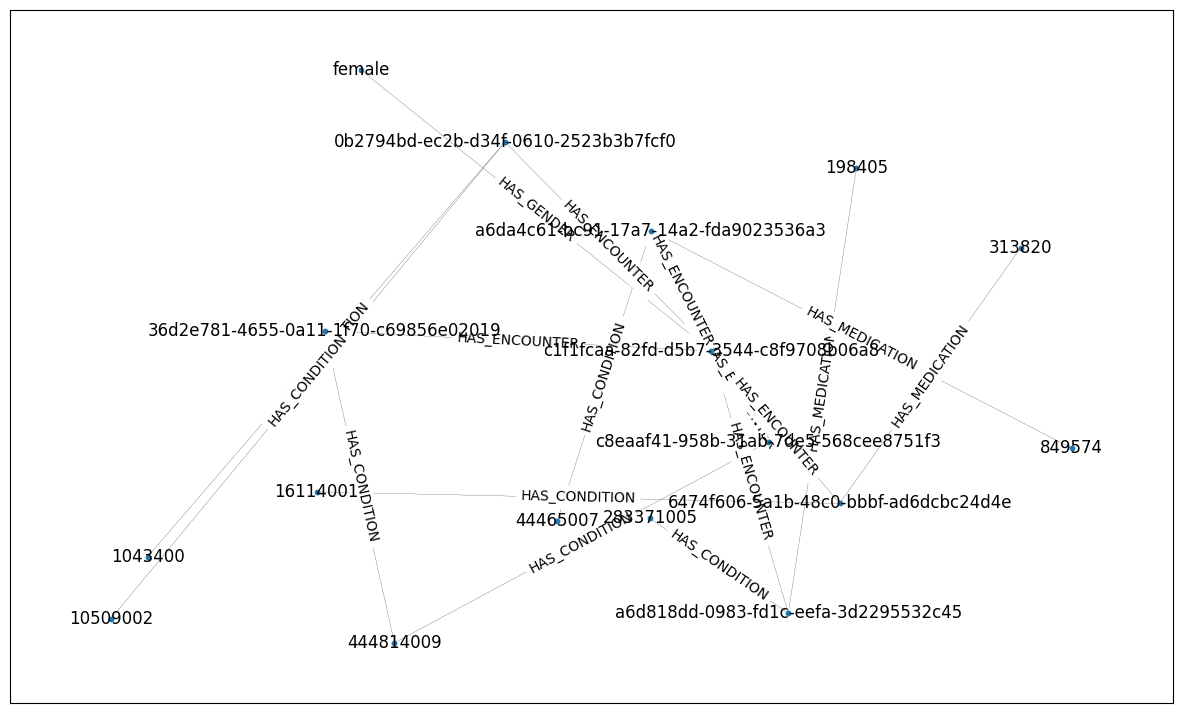

In [149]:
import random

# creating sub graph for limited number of patients to visualize
max_nodes = 1  
# Get all patient nodes
nodes_to_keep = []
patient_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'Patient']

# Sample a subset of patient nodes
# if len(patient_nodes) > max_nodes:
#     sampled_patients = random.sample(patient_nodes, min(max_nodes, len(patient_nodes)))
sampled_patients = patient_nodes[1:2]   

print (f"Number of sampled patients: {len(sampled_patients)}")

# Create a set of nodes to keep for the graph
nodes_to_keep = set(sampled_patients)
for patient in sampled_patients:
    for neighbor in G.neighbors(patient):
        nodes_to_keep.add(neighbor)
        if neighbor not in ['male', 'female', 'married', 'single']:
            for neighbor2 in G.neighbors(neighbor):
                nodes_to_keep.add(neighbor2)
    
print (f"Number of nodes in the subgraph: {len(nodes_to_keep)}")

G_sub = G.subgraph(nodes_to_keep)

#print (nodes_to_keep)

# 3. Visualize the sub Graph 
# Reference: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#visualizing-the-graph

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15, "with_labels": True}
pos = nx.spring_layout(G_sub, iterations=1, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
edge_labels = nx.get_edge_attributes(G_sub, 'relationship')
nx.draw_networkx(G_sub, pos=pos, ax=ax,  **plot_options)
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels)


In [150]:
from arango import ArangoClient
from arango_datasets import Datasets
#Initialize ArangoDB client

client = ArangoClient(hosts="https://5d4260a933d2.arangodb.cloud:8529")  # Use correct format
#Connect to the "_system" database (or use your specific database)

sys_db = client.db("_system", username="root", password="YN6acOVHniTpacWL6xVB")  # No "verify" argument


#sys_db.create_database("health1")

print(sys_db.databases())
health1 = client.db("health1", username="root", password="YN6acOVHniTpacWL6xVB")
#Connect to datasets

datasets = Datasets(health1)
#List available datasets

print(datasets.list_datasets())
#Get information about a specific dataset


Output()

['_system', 'health', 'health1']


['IMDB_X', 'IMDB_PLATFORM', 'AMAZON_COMPUTER_PRODUCTS', 'AMAZON_PRODUCT_WITH_EMBEDDINGS', 'FAKE_HOMO_MULTICLASS', 'FAKE_HOMO_BINARY', 'FAKE_HETRO_LARGE_MULTICLASS', 'MAG', 'OPEN_INTELLIGENCE', 'OPEN_INTELLIGENCE_ANGOLA', 'FLIGHTS', 'CORA', 'DBLP', 'CVE', 'MTCARS', 'P2PSB', 'SCHAIN', 'ITSM_SAGE', 'ABIDE', 'CYBER', 'GAME_OF_THRONES', 'MARKET', 'SYNTHEA_P1000', 'SYNTHEA_P100']


In [151]:
if "health_graph" in health1.graphs():
    print("Graph already exists. Deleting it.")
    health1.delete_graph("health_graph", ignore_missing=True, drop_collections=True)

In [152]:
G_adb = nxadb.Graph(
    name="health_graph",
    db=health1,
    incoming_graph_data=G,
    overwrite_graph=True,
    write_batch_size=50000 # feel free to modify
)

print(G_adb)

[16:34:26 -0800] [INFO]: Overwriting graph 'health_graph'
[16:34:26 -0800] [INFO]: Graph 'health_graph' exists.
[16:34:26 -0800] [INFO]: Default node type set to 'health_graph_node'
[2025/03/07 16:34:27 -0800] [97379] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'health1'


Output()

Output()

[2025/03/07 16:34:40 -0800] [97379] [INFO] - adbnx_adapter: Created ArangoDB 'health_graph' Graph


Graph named 'health_graph' with 40613 nodes and 0 edges


In [153]:
G_adb.degree(1)

0

In [154]:
arango_graph = ArangoGraph(health1)

In [155]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello tell me joke!")

AIMessage(content="Sure, here's one for you:\n\nWhy don't skeletons fight each other?\n\nThey don't have the guts!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 12, 'total_tokens': 34, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-616e500c-614f-4afe-a331-b98414975327-0', usage_metadata={'input_tokens': 12, 'output_tokens': 22, 'total_tokens': 34, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [156]:
# 4. Define the Text to AQL Tool
# Reference: https://python.langchain.com/docs/integrations/graphs/arangodb/
# Reference: https://python.langchain.com/api_reference/community/chains/langchain_community.chains.graph_qa.arangodb.ArangoGraphQAChain.html
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

#text_to_aql_to_text("What is the name of the person who has the most friends?")

# 5. Define the Text to NetworkX/cuGraph Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text


tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, favourite_fruit]

# 6. Create the Agentic Application

# Note: Consider implementing a hybrid tool that combines both AQL & NetworkX Algorithms!

tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, favourite_fruit]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [157]:
query_graph("How many are  patients are male? ")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH health_graph_node
FOR node IN health_graph_node
  FILTER node.node_type == "Gender" AND node.name == "Male"
  COLLECT WITH COUNT INTO length
RETURN length

AQL Result:
[1]

> Finished chain.


'There is one male patient in the database.'

In [158]:
query_graph("How many patients have encounter with condition 'Prediabetes'?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH health_graph_node
FOR v IN health_graph_node
    FILTER v.node_type == 'Condition' AND v.name == 'Prediabetes'
    FOR e IN health_graph_node_to_health_graph_node
        FILTER e._to == v._id
        FOR p IN health_graph_node
            FILTER e._from == p._id AND p.node_type == 'Patient'
            COLLECT WITH COUNT INTO numberOfPatients
RETURN numberOfPatients

AQL Result:
[0]

> Finished chain.


"There are no patients in the database who have had an encounter with the condition 'Prediabetes'."

In [159]:
query_graph("how many patients have encounter with  medications strating with 'Amoxicillin'?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH health_graph_node
FOR node IN health_graph_node
  FILTER node.node_type == 'Medication' AND STARTS_WITH(node.name, 'Amoxicillin')
  COLLECT WITH COUNT INTO count
RETURN count

AQL Result:
[3]

> Finished chain.


"There are 3 patients who have had encounters with medications starting with 'Amoxicillin'."

In [160]:
query_graph("Which patients have a high risk of 'Body mass index 30+ - obesity (finding)' diseases based on their conditions and medications?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH health_graph_node
FOR patient IN health_graph_node
    FILTER patient.node_type == 'Patient'
    LET conditions = (
        FOR v, e, p IN 1..1 OUTBOUND patient health_graph_node_to_health_graph_node
            FILTER v.node_type == 'Condition' AND v.name == 'Body mass index 30+ - obesity (finding)'
            RETURN v
    )
    LET medications = (
        FOR v, e, p IN 1..1 OUTBOUND patient health_graph_node_to_health_graph_node
            FILTER v.node_type == 'Medication'
            RETURN v
    )
    FILTER LENGTH(conditions) > 0
    RETURN {
        patient: patient,
        conditions: conditions,
        medications: medications
    }

AQL Result:
[]

> Finished chain.


"Currently, there are no patients identified in the database with a high risk of 'Body mass index 30+ - obesity (finding)' based on their medical conditions and medications."